In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [4]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [5]:
img = aviris.open('f970619t01p02_r02_sc04.a.rfl', 'f970619t01p02_r02.a.spc')

	Data Source:   '/home/marko/HSI/f970619t01p02r02c/f970619t01p02_r02_sc04.a.rfl'
	# Rows:            512
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


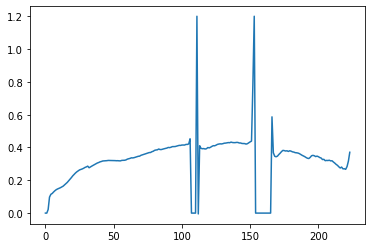

In [6]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

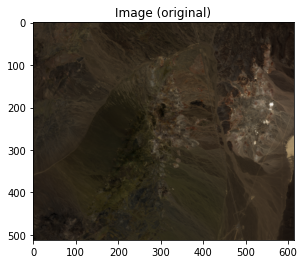

In [7]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [8]:
img = aviris.open('f970619t01p02_r02_sc02.a.rfl', 'f970619t01p02_r02.a.spc')

	Data Source:   '/home/marko/HSI/f970619t01p02r02c/f970619t01p02_r02_sc02.a.rfl'
	# Rows:            512
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


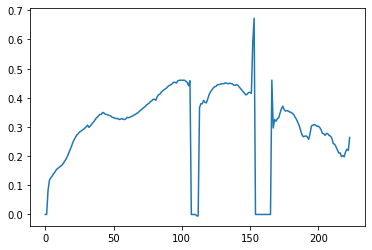

In [9]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

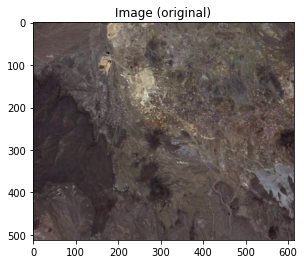

In [10]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [11]:
img = envi.open('f080611t01p00r07rdn_c_sc01_ort_img.hdr')

	Data Source:   '/home/marko/HSI/f080611t01p00r07rdn_c/f080611t01p00r07rdn_c_sc01_ort_img'
	# Rows:           1924
	# Samples:         753
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
>i2


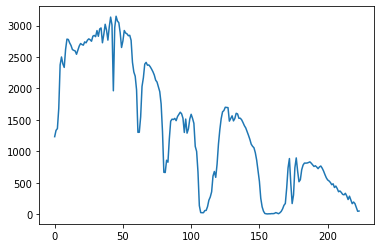

In [12]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

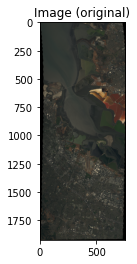

In [13]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [14]:
img = aviris.open('f960705t01p02_r02c_img', 'f960705t01p02_r02.spc')

	Data Source:   '/home/marko/HSI/f960705t01p02r02c/f960705t01p02_r02c_img'
	# Rows:           1087
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


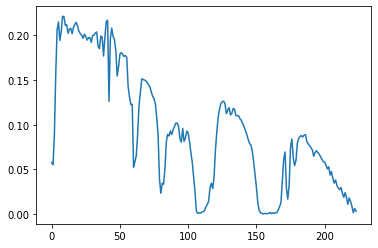

In [15]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

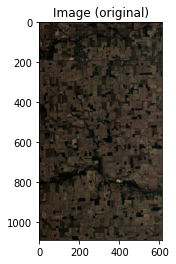

In [16]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [17]:
print(img)

	Data Source:   '/home/marko/HSI/f960705t01p02r02c/f960705t01p02_r02c_img'
	# Rows:           1087
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16


Число каналов:  224
Минимальная длина волн:  370.49
Максимальная длина волн:  2507.59


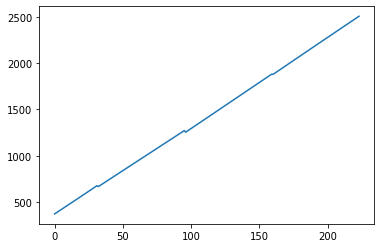

In [18]:
wavelengths_original = np.array(img.bands.centers)
print('Число каналов: ', len(wavelengths_original))
print('Минимальная длина волн: ', min(wavelengths_original))
print('Максимальная длина волн: ', max(wavelengths_original))
pylab.plot(wavelengths_original)

Видно что на трёх местах длина волн не возрастает монотонно. В частности, на 32ом элементе падает.

In [19]:
print(wavelengths_original[28:38])

[645.69 655.56 665.42 675.27 666.02 675.61 685.19 694.78 704.37 713.96]


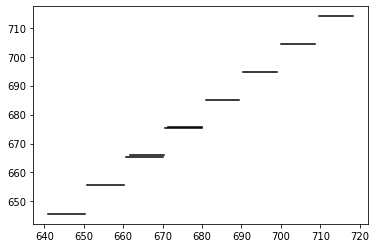

In [20]:
local_wl_centers = np.array(img.bands.centers[28:38])
local_bandwidths = np.array(img.bands.bandwidths[28:38])
band_starts = local_wl_centers - local_bandwidths / 2
band_ends = local_wl_centers + local_bandwidths / 2

pylab.figure()
for (c, s, e) in zip(local_wl_centers, band_starts, band_ends):
    pylab.plot([s, e], [c, c], color='black')

pylab.show()

Кроме того что они не в возрастающем порядке, они также значительно пересекаются. Отсортируем их.

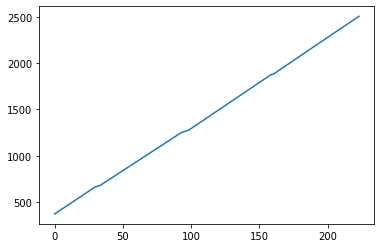

In [21]:
wavelengths_sorted = np.sort(wavelengths_original)
pylab.plot(wavelengths_sorted)

In [22]:
print(img[380, 496])
some_spectrum = img[380, 496].astype(float)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
some_spectrum_resampled = resampler(some_spectrum)

[5.760e-02 5.510e-02 8.910e-02 1.572e-01 2.063e-01 2.149e-01 1.943e-01
 2.041e-01 2.213e-01 2.208e-01 2.111e-01 2.119e-01 2.022e-01 2.069e-01
 2.078e-01 2.018e-01 2.089e-01 2.122e-01 2.145e-01 2.100e-01 2.045e-01
 2.017e-01 2.001e-01 1.967e-01 2.012e-01 1.985e-01 1.947e-01 1.973e-01
 1.975e-01 1.921e-01 1.998e-01 2.002e-01 2.026e-01 2.037e-01 1.875e-01
 1.851e-01 1.992e-01 1.980e-01 1.768e-01 1.975e-01 2.156e-01 2.168e-01
 1.261e-01 1.961e-01 2.080e-01 1.987e-01 1.951e-01 1.832e-01 1.544e-01
 1.647e-01 1.788e-01 1.807e-01 1.789e-01 1.763e-01 1.775e-01 1.753e-01
 1.431e-01 1.310e-01 1.226e-01 1.229e-01 5.250e-02 5.870e-02 6.550e-02
 8.970e-02 1.213e-01 1.364e-01 1.514e-01 1.504e-01 1.500e-01 1.491e-01
 1.472e-01 1.448e-01 1.422e-01 1.366e-01 1.318e-01 1.291e-01 1.232e-01
 1.078e-01 8.770e-02 3.920e-02 2.330e-02 3.460e-02 3.340e-02 5.130e-02
 8.080e-02 8.930e-02 8.740e-02 9.300e-02 8.900e-02 9.460e-02 9.790e-02
 1.018e-01 1.018e-01 9.790e-02 8.430e-02 8.050e-02 9.580e-02 8.130e-02
 8.510

Посмотрим как выглядят графики, оригинальный, с отсортированными длинами волн, и с отсортированными длинами волн и соответствующей корректировкой измерений.

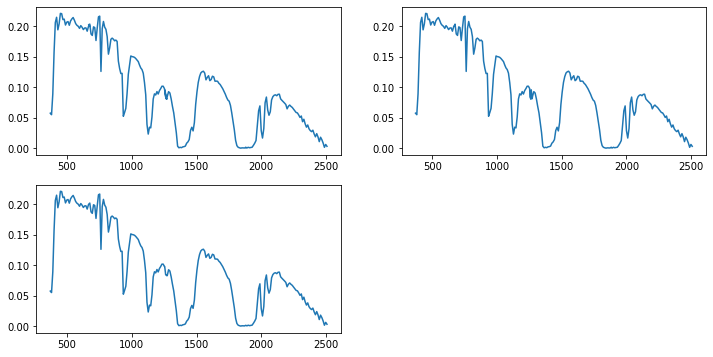

In [23]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original, some_spectrum)
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted, some_spectrum)
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted, some_spectrum_resampled)
pylab.show()

Посмотрим часть которая нам была интересной сначала.

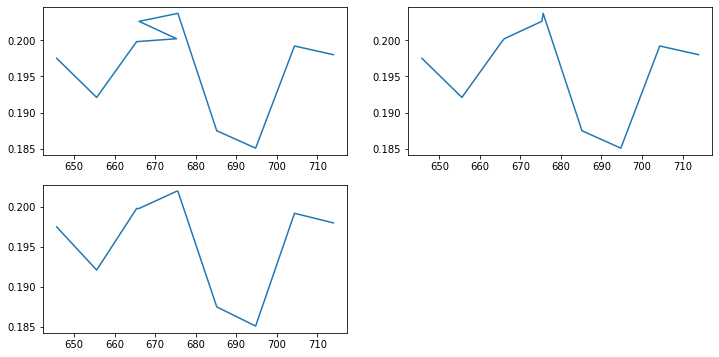

In [24]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[28:38], some_spectrum[28:38])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[28:38], some_spectrum_resampled[28:38])
pylab.show()

Видно что сортировка помогла. Посмотрим ещё одну интересную часть.

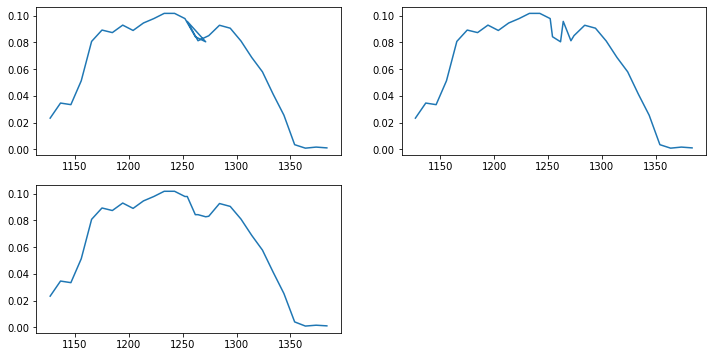

In [25]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[80:110], some_spectrum[80:110])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[80:110], some_spectrum_resampled[80:110])
pylab.show()

Тут ещё видно что нам нужно ещё и значения скорректировать. Поэтому, исправим целое изображение.

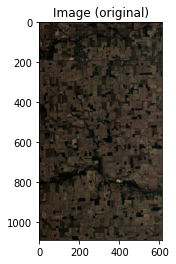

In [26]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [27]:
data = img[:,:,:]
#data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [28]:
data[data < 0] = 0
print(data.dtype)

float64


In [29]:
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)

In [30]:
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

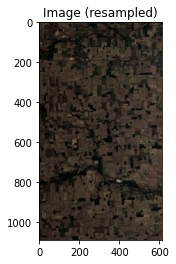

In [31]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

Будем проверять работу алгоритмов используя несколько ~~интересных сигнатур.~~

1. ~~Травы~~
2. ~~Асфальта~~
3. ~~Морской воды~~
4. ~~Бетона~~

Надо упомянуть что особенно травы и воды могут быть разные. Вода может быть в большей или меньшей степени загрязненной, трава свежей или сухой, итд. Все ниже выбранные сигнатуры находятся около самого аэродрома.

In [48]:
interesting_spectra = [data[1000, 496].astype(float),
                          data[227, 423].astype(float),
                          data[877, 505].astype(float),
                          data[258, 199].astype(float),
                         ]
interesting_colors = ['green', 'darkgrey', 'blue', 'lightgrey']
interesting_continuum_colors =  ['lightgreen', 'grey', 'lightblue', 'yellow']

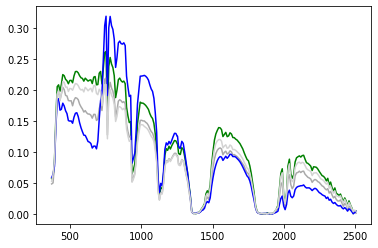

In [49]:
from visual_utils import draw_ontop
draw_ontop(interesting_spectra, wavelengths, interesting_colors)

Проверим работу функции удаления континуума написанных на С.

Проверим работу функции удаления континуума на питоне.

In [55]:
from utils import filter_out_invalid_spectra
from spectral.algorithms.continuum import remove_continuum
spectra = filter_out_invalid_spectra(data)

In [61]:
avg = np.average(spectra, axis=0)
cr_avg = remove_continuum(avg, wavelengths)

In [62]:
maxes = np.max(spectra, axis=0)
cr_maxes = remove_continuum(maxes, wavelengths)

In [63]:
from math_utils import find_max_diff_l2
max_diff_l2 = find_max_diff_l2(spectra, avg)
cr_max_diff_l2 = remove_continuum(max_diff_l2, wavelengths)

In [64]:
from math_utils import find_max_diff_l1
max_diff_l1 = find_max_diff_l1(spectra, avg)
cr_max_diff_l1 = remove_continuum(max_diff_l1, wavelengths)

In [65]:
from math_utils import find_max_diff_angle
max_diff_angle = find_max_diff_angle(spectra, avg)
cr_max_diff_angle = remove_continuum(max_diff_angle, wavelengths)

In [66]:
from math_utils import find_with_max_norm2
max_norm2 = find_with_max_norm2(spectra)
cr_max_norm2 = remove_continuum(max_norm2, wavelengths)

In [67]:
from math_utils import find_with_max_norm1
max_norm1 = find_with_max_norm1(spectra)
cr_max_norm1 = remove_continuum(max_norm1, wavelengths)

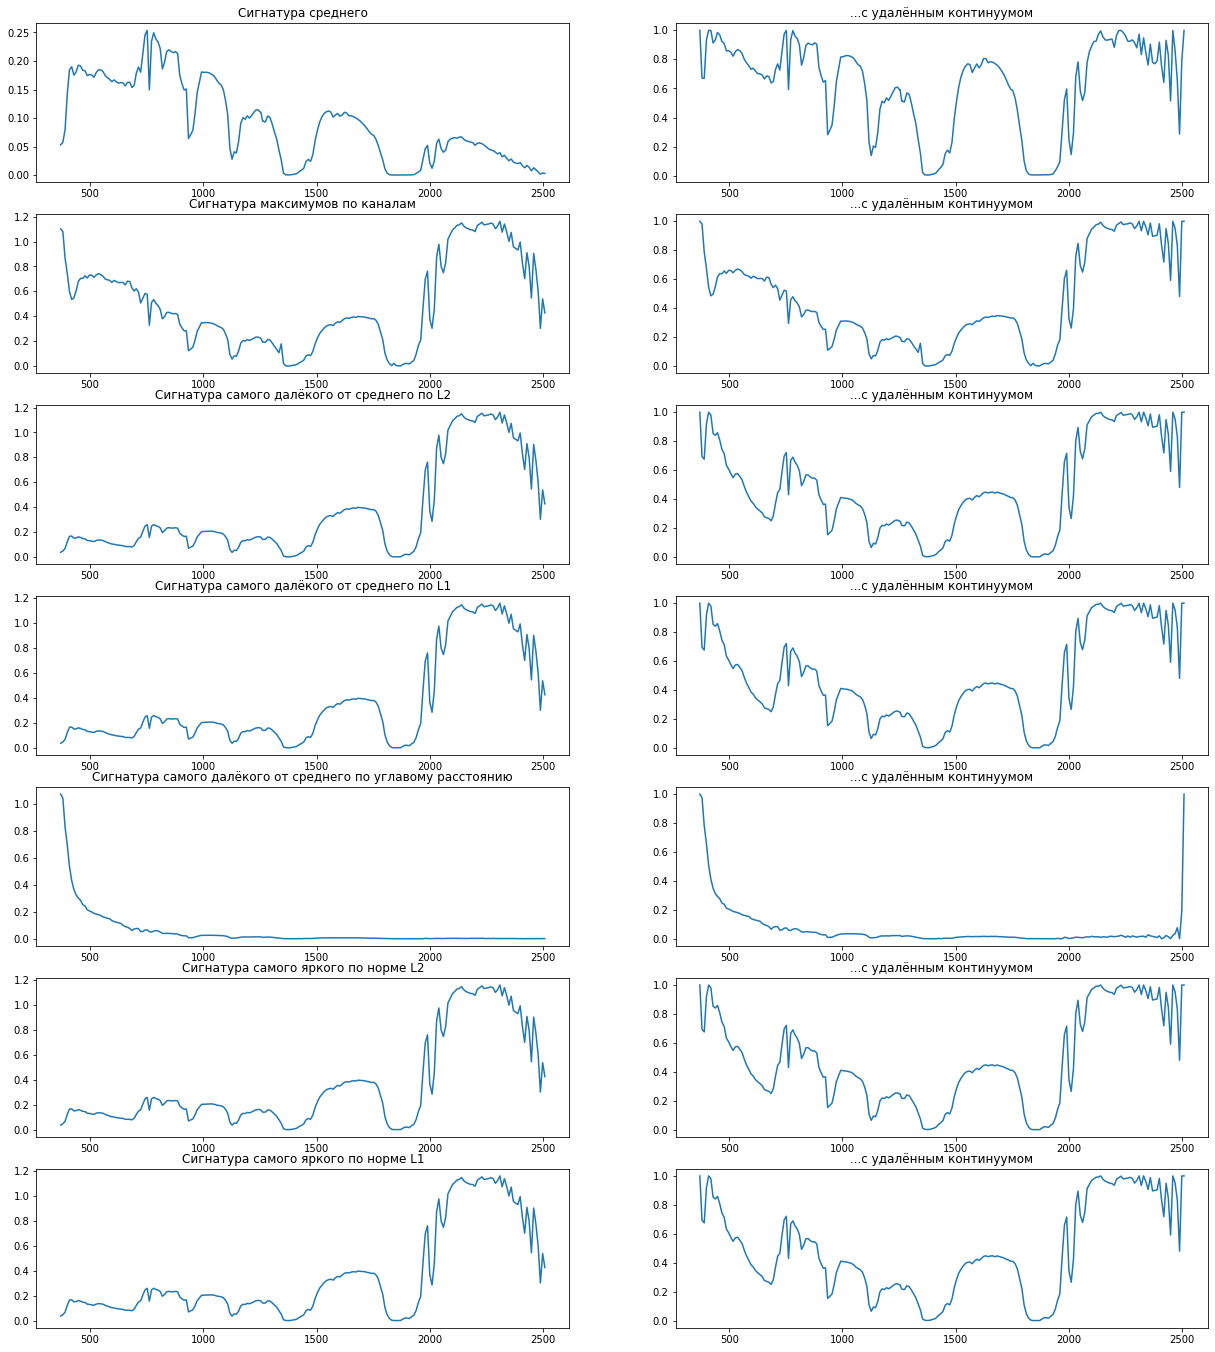

In [68]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*3, 2*12)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 2, (i*2)+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(wavelengths, figs[i]['sig'])
    ax = pylab.subplot(len(figs), 2, (i*2)+2)
    ax.set_title(figs[i]['cr-title'])
    pylab.plot(wavelengths, figs[i]['cr-sig'])

pylab.show()

Посмотрим где находится самая отличающаяся сигнатура.

In [69]:
from utils import find_image_coords_of_spectrum
coords = find_image_coords_of_spectrum(data, max_diff_l2)
print(coords)

(209, 340)
